In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torchmetrics

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import pickle

In [ ]:
class EWC_loss(nn.Module):
    def __init__(self, model: nn.Module, information_matrix, lambda_ewc, loss_fn):
        super(EWC_loss, self).__init__()
        self.original_params = {name: param.detach().clone() for name, param in model.named_parameters()}
        self.information_matrix = information_matrix
        self.lambda_ewc = lambda_ewc
        self.loss_fn = loss_fn
    
    def forward(self, model, x, y):
        # Compute the loss
        loss = self.loss_fn(model(x), y)
        
        # Compute the EWC penalty
        ewc_penalty = 0
        for name, param in model.named_parameters():
            if name in self.original_params:
                ewc_penalty += (self.information_matrix[name] * (param - self.original_params[name]) ** 2).sum()
        
        # Combine the loss and the EWC penalty
        total_loss = loss + self.lambda_ewc * ewc_penalty
        
        return total_loss

In [ ]:
SESSION = 'MNIST_EWC'

LOAD_INDICES=False
LOAD_MODELS=False
LOAD_INFORMATIONS=False

SESSIONS_PATH = 'sessions/'

In [4]:
session_path = os.path.join(SESSIONS_PATH, SESSION)
indices_path = os.path.join(session_path, f'{SESSION}_indices.pkl')
trained_model_path = os.path.join(session_path, f'{SESSION}_trained.pt')
benchmark_model_path = os.path.join(session_path, f'{SESSION}_benchmark.pt')
informations_path = os.path.join(session_path, f'{SESSION}_informations.pkl')

if not os.path.exists(SESSIONS_PATH):
    os.makedirs(SESSIONS_PATH)

if not os.path.exists(session_path):
    os.makedirs(session_path)

if LOAD_INDICES and not os.path.exists(indices_path):
    raise FileNotFoundError(f"Indices file not found at {indices_path}.")
if not LOAD_INDICES and os.path.exists(indices_path):
    raise FileExistsError(f"Indices file already exists at {indices_path}.")
if LOAD_MODELS and not os.path.exists(trained_model_path):
    raise FileNotFoundError(f"Trained model file not found at {trained_model_path}.")
if not LOAD_MODELS and os.path.exists(trained_model_path):
    raise FileExistsError(f"Trained model file already exists at {trained_model_path}.")
if LOAD_MODELS and not os.path.exists(benchmark_model_path):
    raise FileNotFoundError(f"Benchmark model file not found at {benchmark_model_path}.")
if not LOAD_MODELS and os.path.exists(benchmark_model_path):
    raise FileExistsError(f"Benchmark model file already exists at {benchmark_model_path}.")
if LOAD_INFORMATIONS and not os.path.exists(informations_path):
    raise FileNotFoundError(f"Informations file not found at {informations_path}.")
if not LOAD_INFORMATIONS and os.path.exists(informations_path):
    raise FileExistsError(f"Informations file already exists at {informations_path}.")

In [5]:
transform = transforms.ToTensor()
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Print number of samples in the dataset
print(f"Number of samples in the dataset: {len(dataset)}")

Number of samples in the dataset: 60000


In [ ]:
from fisherunlearn.clients_utils import split_dataset_by_class_distribution

# Compute the number of classes
num_classes = len(dataset.classes)

classes_distributions = np.zeros((num_classes, num_classes))
for i in range(num_classes):
    classes_distributions[i][i] = 1
    
classes_subsets = split_dataset_by_class_distribution(dataset, classes_distributions)

classes_dataloaders = [DataLoader(subset, batch_size=64, shuffle=True) for subset in classes_subsets]

Number of samples in the subset: 12000
Number of samples in the subset: 12000
Number of samples in the subset: 12000
Number of samples in the subset: 12000
Number of samples in the subset: 12000


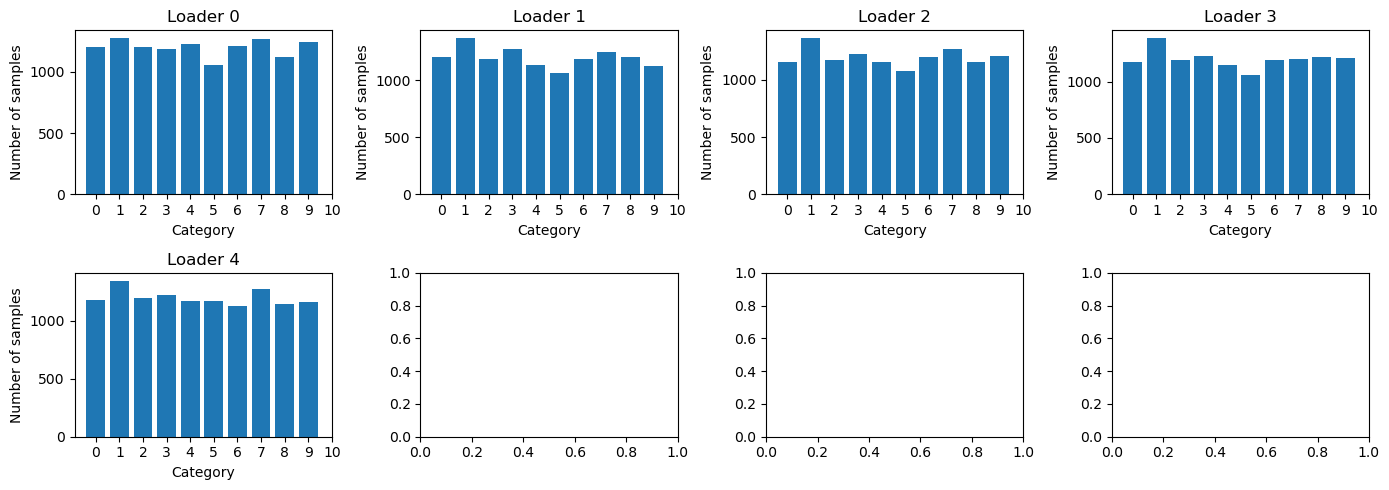

Total samples for class 0: 5923
Total samples for class 1: 6742
Total samples for class 2: 5958
Total samples for class 3: 6131
Total samples for class 4: 5842
Total samples for class 5: 5421
Total samples for class 6: 5918
Total samples for class 7: 6265
Total samples for class 8: 5851
Total samples for class 9: 5949


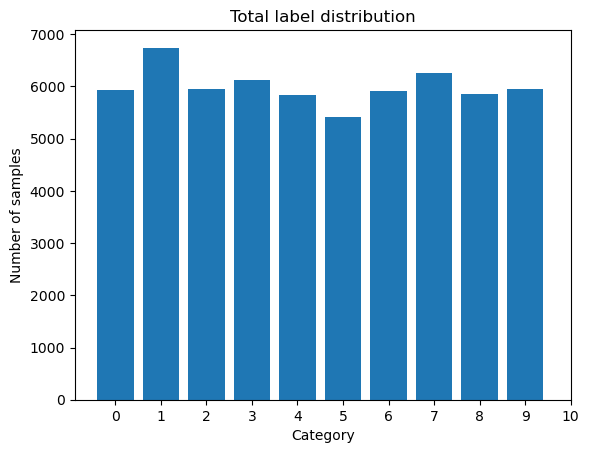

In [ ]:
from collections import Counter

def get_label_distribution(dataloader):
    label_counts = Counter()
    for _, labels in dataloader:
        label_counts.update(labels.tolist())
    return dict(label_counts)

# Choose dataloader list to visualize
dataloaders = classes_dataloaders
num_classes_vis = num_classes

width = np.ceil(np.sqrt(2*len(dataloaders))).astype(int)
height = np.ceil(width/2).astype(int)

axs = fig, axs = plt.subplots(height, width, figsize=(14, 5))
label_distributions = []
for i, loader in enumerate(dataloaders):
    label_distribution = get_label_distribution(loader)
    label_distributions.append(label_distribution)
    axs[i//width][i%width].bar(label_distribution.keys(), label_distribution.values())
    axs[i//width][i%width].set_title(f'Loader {i}')
    axs[i//width][i%width].set_xlabel('Category')
    axs[i//width][i%width].set_xticks(range(num_classes_vis+1))
    axs[i//width][i%width].set_ylabel('Number of samples')

plt.tight_layout()
plt.show()

total_label_distribution = {}
for key in range(num_classes_vis):
    total_label_distribution[key] = 0
    for distribution in label_distributions:
        if key in distribution:
            total_label_distribution[key] += distribution[key]

plt.bar(total_label_distribution.keys(), total_label_distribution.values())
plt.title('Total label distribution')
plt.xlabel('Category')
plt.xticks(range(num_classes_vis+1))
plt.ylabel('Number of samples')
plt.show()

In [ ]:
class FLNet(nn.Sequential):
    def __init__(self):
        super(FLNet, self).__init__(
            nn.Conv2d(1, 32, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

test_model = FLNet()
model_parameters = filter(lambda p: p.requires_grad, test_model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Number of parameters in the model: {params}")

Number of parameters in the model: 1663370


In [ ]:
def compute_accuracy(model, dataloader, device=None):
    if device is None:
        device_ = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device_ = device
        
    model.to(device_)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device_), labels.to(device_)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    if device is None:
        model.cpu()

    return correct / total

def compute_dataloaders_accuracy(model, dataloaders):
    accuracies = []
    for idx, dataloader in enumerate(dataloaders):
        accuracy = compute_accuracy(model, dataloader)
        accuracies.append(accuracy)
    return accuracies

# create validation routine
def validate(model, dataloaders, num_classes, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    # create metric objects
    tm_acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes, average= 'macro', top_k=1)
    tm_con = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=num_classes)
    # move metric to device
    model.to(device)
    tm_acc.to(device)
    tm_con.to(device)
    # set network in eval mode
    model.eval()
    # at the end of epoch, validate model
    for loader_idx, loader in enumerate(dataloaders):
        for inputs, targets in loader:
        
            inputs = inputs.to(device)
            targets = targets.to(device)
            # remove singleton dimension
            targets = targets.squeeze()
            # get output
            with torch.no_grad():
                # perform prediction
                logits = model(inputs)
            # update metrics
            _, predicted = torch.max(logits.data, 1)
            tm_acc.update(predicted, targets)
            tm_con.update(predicted, targets)

    # at the end, compute metric
    acc = tm_acc.compute()
    con = tm_con.compute()
    # set network in training mode
    
    return acc, con


def plot_confusion_matrix(conf_mat):
    cm = sns.light_palette("blue", as_cmap=True)
    x=pd.DataFrame(conf_mat.cpu())
    x=x.style.background_gradient(cmap=cm)
    display(x)

In [ ]:
def trainer(model, loss_fn, dataloader, epochs):
    torch.cuda.empty_cache()
    # Training loop
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    #device = "cpu"
    model.to(device)

    for epoch in range(epochs):
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            loss = loss_fn(preds, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Evaluate on test set
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
        
    return model

# Save the model
def save_model_with_unique_name(model, base_path):
    # Split the base_path into the file name and extension
    base, ext = os.path.splitext(base_path)
    new_path = base_path
    counter = 1
    
    # Check if the file exists and update the filename if needed
    while os.path.exists(new_path):
        new_path = f"{base}({counter}){ext}"
        counter += 1

    torch.save(model.state_dict(), new_path)
    print(f"Model saved to {new_path}")

In [ ]:
from fisherunlearn.clients_utils import concatenate_subsets
from fisherunlearn import compute_informations

# Model
model = FLNet()
model_benchmark = FLNet()
loss_fn = nn.CrossEntropyLoss()

if not LOAD_MODELS:
    initial_subset = concatenate_subsets(classes_subsets[:2])
    initial_dataloader = DataLoader(initial_subset, batch_size=64, shuffle=True)
    model = trainer(model, loss_fn, initial_dataloader, epochs=1)
    informations = compute_informations(model, loss_fn, classes_dataloaders[:2])
    avg_information = {name: sum([information[name] for information in informations]) / len(informations) for name in informations[0].keys()}

    
    for i, loader in enumerate(classes_dataloaders):


else:
    model.load_state_dict(torch.load(trained_model_path, weights_only=True))
    model_benchmark.load_state_dict(torch.load(benchmark_model_path, weights_only=True))

cuda
Epoch 1/10, Loss: 0.0523
Epoch 2/10, Loss: 0.0043
Epoch 3/10, Loss: 0.0065
Epoch 4/10, Loss: 0.0514
Epoch 5/10, Loss: 0.0258
Epoch 6/10, Loss: 0.0009
Epoch 7/10, Loss: 0.0091
Epoch 8/10, Loss: 0.0017
Epoch 9/10, Loss: 0.0031
Epoch 10/10, Loss: 0.0000
cuda
Epoch 1/10, Loss: 0.0261
Epoch 2/10, Loss: 0.0103
Epoch 3/10, Loss: 0.0015
Epoch 4/10, Loss: 0.0030
Epoch 5/10, Loss: 0.0098
Epoch 6/10, Loss: 0.0217
Epoch 7/10, Loss: 0.0000
Epoch 8/10, Loss: 0.0012
Epoch 9/10, Loss: 0.0002
Epoch 10/10, Loss: 0.0036


In [ ]:
from fisherunlearn import compute_informations

if not LOAD_INFORMATIONS:
    assert not os.path.exists(informations_path), f"Informations already exists at {informations_path}."
    
    informations = compute_informations(model, loss_fn, client_dataloaders, use_converter=True)

    with open(informations_path, 'wb') as f:
            pickle.dump(informations, f)
else:
    with open(informations_path, 'rb') as f:
        informations = pickle.load(f)

Computing clients information: 100%|██████████| 940/940 [00:43<00:00, 21.75batch/s]
